In [1]:
from pathlib import Path
from zipfile import ZipFile
import fiona.drvsupport
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.ops import nearest_points 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LassoCV
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 2011~2013年を学習データ
# 2014年をテストデータ

In [2]:
# x,y_train
gdf_grid_x = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_grid_500_2011_13.geojson')
gdf_grid_y = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_grid_500.geojson')
# x_test
gdf_grid_x_test = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_grid_500_2014_test.geojson')

In [3]:
gdf_grid_x_test.columns

Index(['centroid_x', 'centroid_y', 'crime_cnt_2010', 'crime_cnt_2011',
       'crime_cnt_2012', 'crime_cnt_2013', 'crime_cnt_2014', 'crime_cnt_2015',
       'crime_cnt_2016', 'crime_cnt_2017', 'crime_cnt_2018', 'crime_cnt_2019',
       'crime_cnt_2020', 'crime_cnt_2021', 'crime_cnt_2022', 'crime_cnt_2023',
       'Alley_271_DST', 'Alley_519_DST', 'Alley_779_DST', 'Alley_999_DST',
       'Alley_271_KDE', 'Alley_519_KDE', 'Alley_779_KDE', 'Alley_999_KDE',
       'Foreclosure_271_DST', 'Foreclosure_519_DST', 'Foreclosure_779_DST',
       'Foreclosure_999_DST', 'Foreclosure_271_KDE', 'Foreclosure_519_KDE',
       'Foreclosure_779_KDE', 'Foreclosure_999_KDE', 'Graffiti_271_DST',
       'Graffiti_519_DST', 'Graffiti_779_DST', 'Graffiti_999_DST',
       'Graffiti_271_KDE', 'Graffiti_519_KDE', 'Graffiti_779_KDE',
       'Graffiti_999_KDE', 'Sanitation_271_DST', 'Sanitation_519_DST',
       'Sanitation_779_DST', 'Sanitation_999_DST', 'Sanitation_271_KDE',
       'Sanitation_519_KDE', 'Sanitatio

In [4]:
gdf_grid_x.columns

Index(['centroid_x', 'centroid_y', 'crime_cnt_2010', 'crime_cnt_2011',
       'crime_cnt_2012', 'crime_cnt_2013', 'crime_cnt_2014', 'crime_cnt_2015',
       'crime_cnt_2016', 'crime_cnt_2017', 'crime_cnt_2018', 'crime_cnt_2019',
       'crime_cnt_2020', 'crime_cnt_2021', 'crime_cnt_2022', 'crime_cnt_2023',
       'Alley_271_DST', 'Alley_519_DST', 'Alley_779_DST', 'Alley_999_DST',
       'Alley_271_KDE', 'Alley_519_KDE', 'Alley_779_KDE', 'Alley_999_KDE',
       'Foreclosure_271_DST', 'Foreclosure_519_DST', 'Foreclosure_779_DST',
       'Foreclosure_999_DST', 'Foreclosure_271_KDE', 'Foreclosure_519_KDE',
       'Foreclosure_779_KDE', 'Foreclosure_999_KDE', 'Graffiti_271_DST',
       'Graffiti_519_DST', 'Graffiti_779_DST', 'Graffiti_999_DST',
       'Graffiti_271_KDE', 'Graffiti_519_KDE', 'Graffiti_779_KDE',
       'Graffiti_999_KDE', 'Sanitation_271_DST', 'Sanitation_519_DST',
       'Sanitation_779_DST', 'Sanitation_999_DST', 'Sanitation_271_KDE',
       'Sanitation_519_KDE', 'Sanitatio

In [5]:
gdf_grid_y.columns

Index(['centroid_x', 'centroid_y', 'crime_cnt_2010', 'crime_cnt_2011',
       'crime_cnt_2012', 'crime_cnt_2013', 'crime_cnt_2014', 'crime_cnt_2015',
       'crime_cnt_2016', 'crime_cnt_2017', 'crime_cnt_2018', 'crime_cnt_2019',
       'crime_cnt_2020', 'crime_cnt_2021', 'crime_cnt_2022', 'crime_cnt_2023',
       'geometry'],
      dtype='object')

In [6]:
gdf_grid_y['crime_cnt_2011_13'] = gdf_grid_y['crime_cnt_2011'] + gdf_grid_y['crime_cnt_2012'] + gdf_grid_y['crime_cnt_2013']

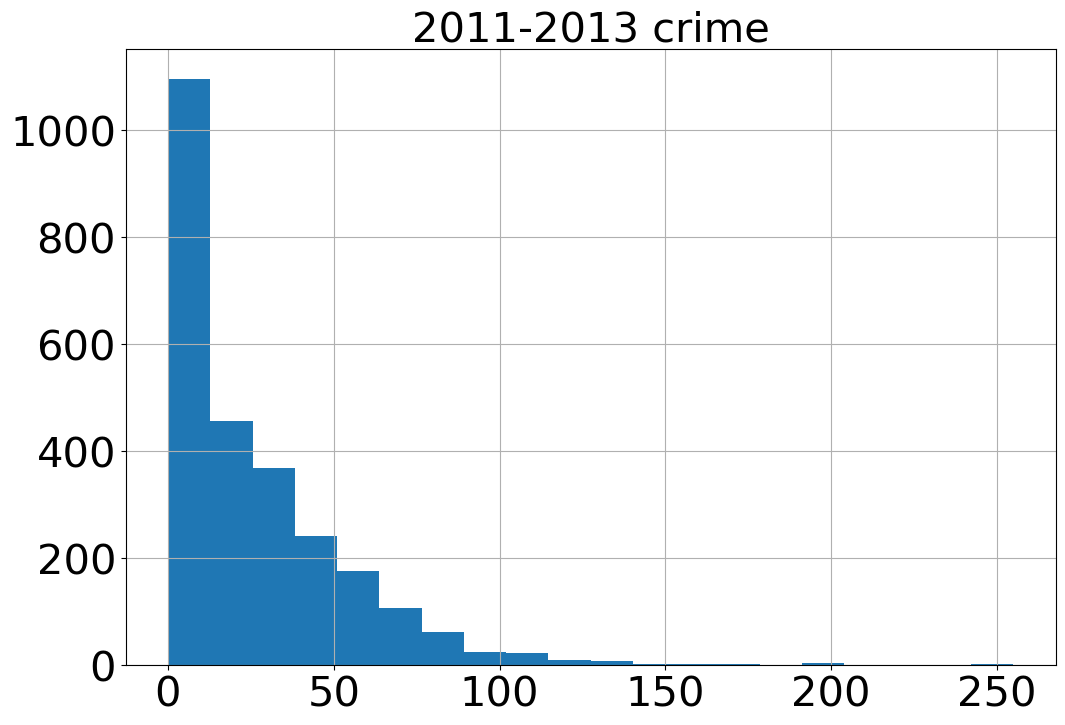

In [7]:
# ヒストグラムを描画
ax = gdf_grid_y[['crime_cnt_2011_13']].hist(bins=20, figsize=(12, 8))

# y軸の目盛の大きさを変更
plt.yticks(fontsize=30)  
plt.xticks(fontsize=30)  
plt.title(label='2011-2013 crime',fontsize=30)
# グラフを表示
plt.show()

array([[<Axes: title={'center': 'crime_cnt_2011_13'}>]], dtype=object)

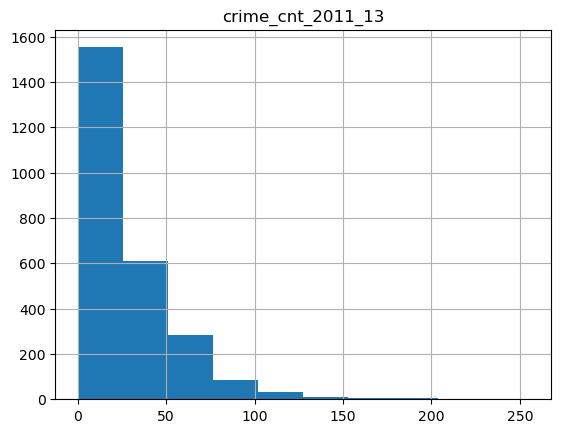

In [8]:
gdf_grid_y[['crime_cnt_2011_13']].hist()

<Axes: >

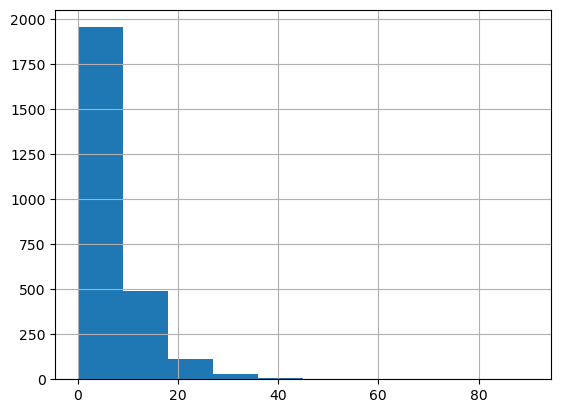

In [9]:
gdf_grid_x_test['crime_cnt_2014'].hist()

# yeo-johnson変換で正規分布に近づける

In [10]:
# 2Darrayに変換
data = np.array(gdf_grid_y[['crime_cnt_2011_13']]).reshape(-1,1)
# 変換
pt = PowerTransformer()
pt.fit(data)
gdf_grid_y[['crime_cnt_2011_13_bc']] = pt.transform(data)

In [11]:
# 2Darrayに変換
data = np.array(gdf_grid_x_test['crime_cnt_2014']).reshape(-1,1)
# 変換
pt = PowerTransformer()
pt.fit(data)
gdf_grid_x_test[['crime_cnt_2014_bc']] = pt.transform(data)

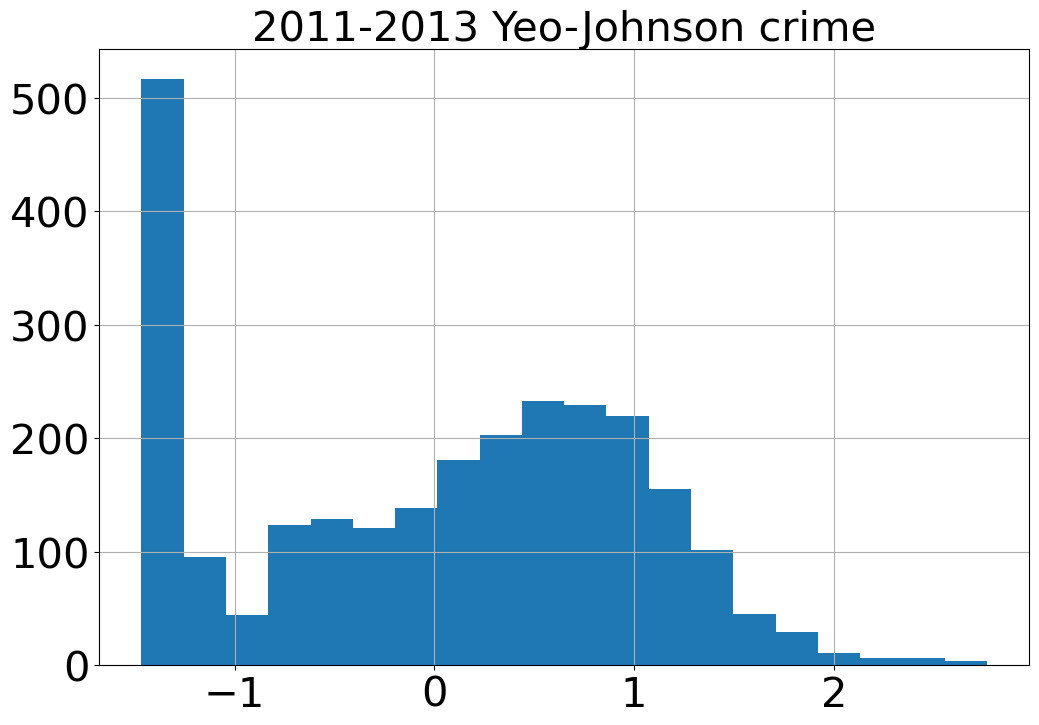

In [12]:
# ヒストグラムを描画
ax = gdf_grid_y[['crime_cnt_2011_13_bc']].hist(bins=20, figsize=(12, 8))

# y軸の目盛の大きさを変更
plt.yticks(fontsize=30)  
plt.xticks(fontsize=30)  
plt.title(label='2011-2013 Yeo-Johnson crime',fontsize=30)
# グラフを表示
plt.show()

array([[<Axes: title={'center': 'crime_cnt_2014_bc'}>]], dtype=object)

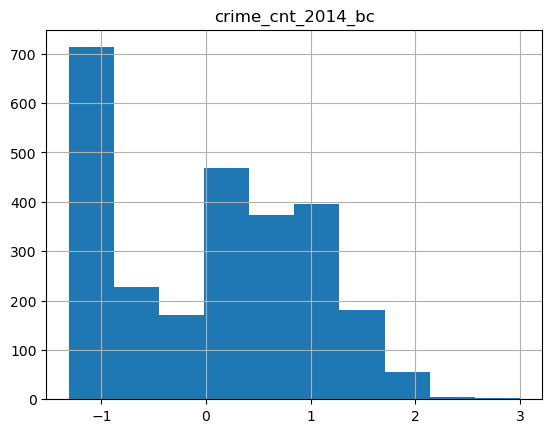

In [13]:
gdf_grid_x_test[['crime_cnt_2014_bc']].hist()

# LassoCVで適切なαを探索

In [14]:
feature_name_list = list(gdf_grid_x_test.columns[16:-2])

In [15]:
# データ準備
X_train = gdf_grid_x[feature_name_list]
y_train = gdf_grid_y['crime_cnt_2011_13_bc']
X_test = gdf_grid_x_test[feature_name_list]
y_test = gdf_grid_x_test['crime_cnt_2014_bc']

In [16]:
# CVの実行
lasso = LassoCV(cv=20, random_state=0).fit(X_train, y_train)

In [17]:
lasso.alpha_

0.0009671737406425796

In [18]:
lasso.feature_names_in_

array(['Alley_271_DST', 'Alley_519_DST', 'Alley_779_DST', 'Alley_999_DST',
       'Alley_271_KDE', 'Alley_519_KDE', 'Alley_779_KDE', 'Alley_999_KDE',
       'Foreclosure_271_DST', 'Foreclosure_519_DST',
       'Foreclosure_779_DST', 'Foreclosure_999_DST',
       'Foreclosure_271_KDE', 'Foreclosure_519_KDE',
       'Foreclosure_779_KDE', 'Foreclosure_999_KDE', 'Graffiti_271_DST',
       'Graffiti_519_DST', 'Graffiti_779_DST', 'Graffiti_999_DST',
       'Graffiti_271_KDE', 'Graffiti_519_KDE', 'Graffiti_779_KDE',
       'Graffiti_999_KDE', 'Sanitation_271_DST', 'Sanitation_519_DST',
       'Sanitation_779_DST', 'Sanitation_999_DST', 'Sanitation_271_KDE',
       'Sanitation_519_KDE', 'Sanitation_779_KDE', 'Sanitation_999_KDE',
       'School_271_DST', 'School_519_DST', 'School_779_DST',
       'School_999_DST', 'School_271_KDE', 'School_519_KDE',
       'School_779_KDE', 'School_999_KDE', 'SLO_271_DST', 'SLO_519_DST',
       'SLO_779_DST', 'SLO_999_DST', 'SLO_271_KDE', 'SLO_519_KDE',
     

In [19]:
lasso.coef_

array([ 0.3360575 , -0.02816586, -0.02471064, -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.40302921, -0.05388897,
       -0.02746284, -0.        ,  0.15586992,  0.        ,  0.        ,
        0.        ,  0.17186727, -0.        , -0.        , -0.        ,
       -0.        , -0.06005682,  0.02466861, -0.        ,  0.30533587,
       -0.08532088, -0.        , -0.        ,  0.19026876,  0.        ,
        0.        ,  0.        ,  0.13320795,  0.24738412,  0.15482057,
        0.06296394,  0.03837625, -0.        ,  0.        ,  0.        ,
       -0.13937669, -0.        , -0.        , -0.        ,  0.10492045,
        0.        ,  0.        ,  0.        ,  0.53271455,  0.00817948,
       -0.05878811, -0.        ,  0.36625097,  0.        ,  0.00646592,
        0.18854049,  0.21502395, -0.0254655 , -0.        , -0.        ,
        0.21573051,  0.38213188,  0.        ,  0.        ])

In [20]:
gdf_grid_x_test['crime_pred'] = lasso.predict(X_test)

array([[<Axes: title={'center': 'crime_pred'}>]], dtype=object)

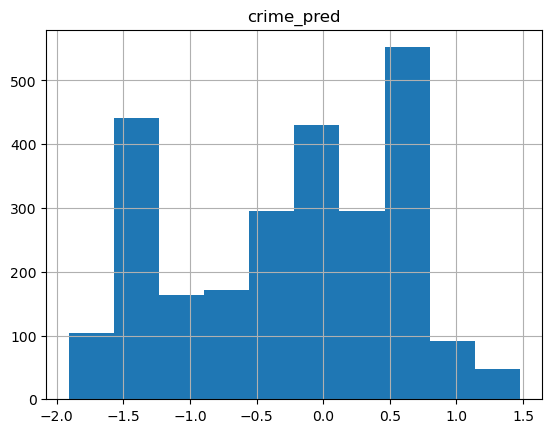

In [21]:
gdf_grid_x_test[['crime_pred']].hist()

# confusion matrix

### 精度を図示
### train,testsplitは別の年代で

In [22]:
# 閾値を計算
y_true = y_test
y_pred = gdf_grid_x_test['crime_pred']
y_true_std = np.std(y_true)
y_true_mean = np.mean(y_true)
y_pred_std = np.std(y_pred)
y_pred_mean = np.mean(y_pred)
# matrixを作成
y_true_bins = [-np.inf, y_true_mean, y_true_mean+y_true_std, y_true_mean+2*y_true_std, np.inf]
y_pred_bins = [-np.inf, y_pred_mean, y_pred_mean+y_pred_std, y_pred_mean+2*y_pred_std, np.inf]
names = ['<mean', 'mean to 1SD', '1SD to 2SD', '+2SD to max']

gdf_grid_x_test['crime_cnt_bc_ctg'] = pd.cut(y_true, y_true_bins, labels=names)
gdf_grid_x_test['crime_pred_ctg'] = pd.cut(y_pred, y_pred_bins, labels=names)

<Axes: >

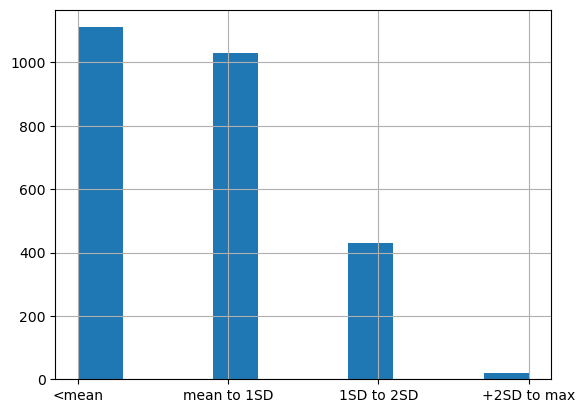

In [23]:
gdf_grid_x_test['crime_cnt_bc_ctg'].hist()

<Axes: >

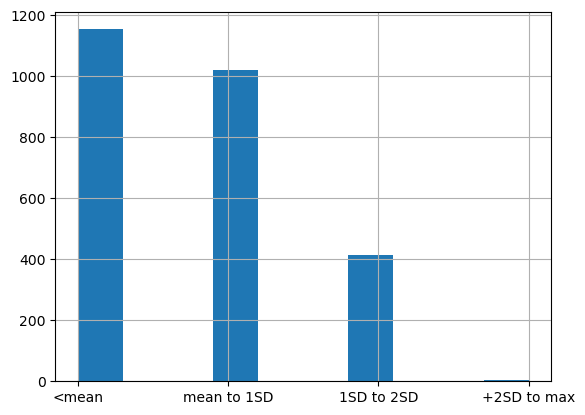

In [24]:
gdf_grid_x_test['crime_pred_ctg'].hist()

# confusion matrixで精度評価

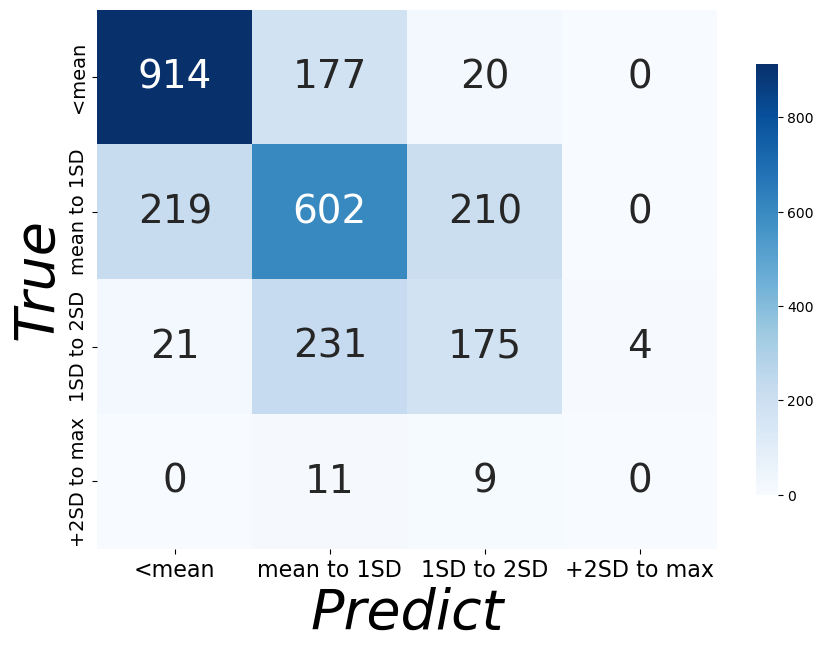

In [25]:
# confusion matrixを描画するための関数
y_true=gdf_grid_x_test['crime_cnt_bc_ctg']
y_pred=gdf_grid_x_test['crime_pred_ctg']
names = ['<mean', 'mean to 1SD', '1SD to 2SD', '+2SD to max']


cmx_data = confusion_matrix(y_true, y_pred, labels=names)
df_cmx = pd.DataFrame(cmx_data, index=names, columns=names)

plt.figure(figsize = (10,7))
sns.heatmap(df_cmx, annot=True, cmap='Blues', fmt='d' ,cbar_kws={"shrink": 0.8},
            annot_kws={"size": 28}) 
# ラベルのフォントサイズを変更
plt.xticks(fontsize=16)  # x軸ラベルのフォントサイズ
plt.yticks(fontsize=14)  # y軸ラベルのフォントサイズ
plt.xlabel(xlabel='Predict', fontsize=40, fontstyle='italic')
plt.ylabel(ylabel='True', fontsize=40, fontstyle='italic')
plt.show()

In [28]:
gdf_BURGLARY_2014 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_BURGLARY_2014.geojson')
gdf_chicago = gpd.read_file('/root/workdir/data/RTM/gdf/chicago.geojson').to_crs(epsg=26971)

Text(0.5, 1.0, 'Actual crime')

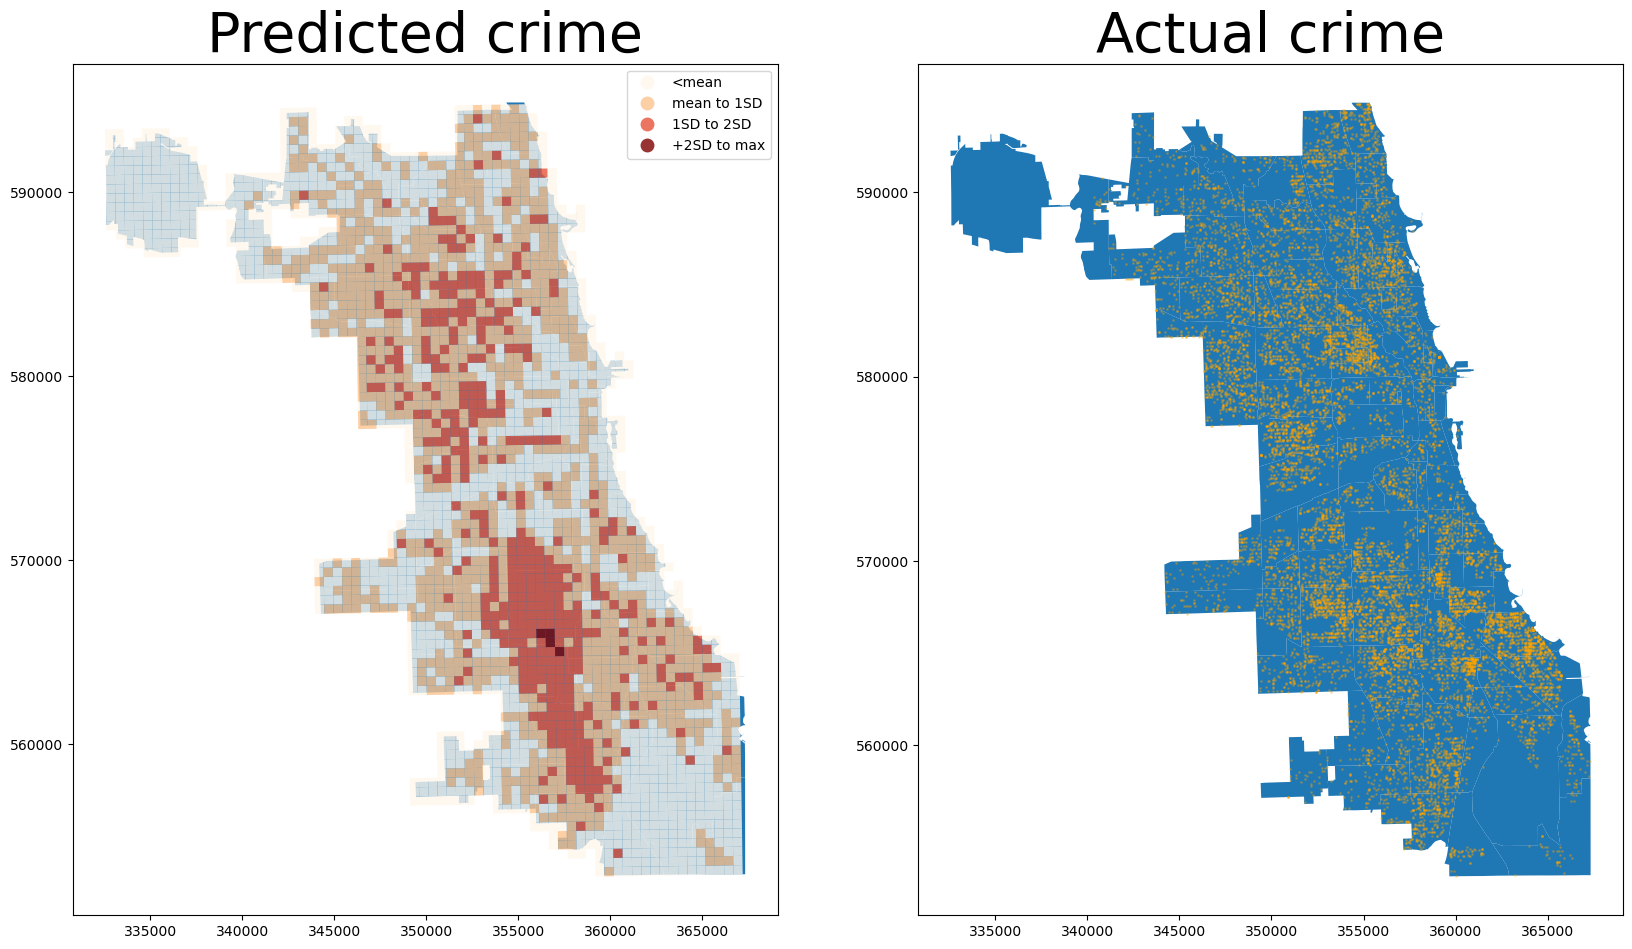

In [57]:
fig, axes = plt.subplots(1,2, figsize=(20,12))
gdf_chicago.plot(ax=axes[0])
gdf_grid_x_test.plot(ax=axes[0], column="crime_pred_ctg", legend=True, alpha=0.8, cmap='OrRd')
axes[0].set_title("Predicted crime", fontsize=40)
gdf_chicago.plot(ax=axes[1])
gdf_BURGLARY_2014.plot(ax=axes[1],markersize=1, alpha=0.3, color='orange' )
axes[1].set_title("Actual crime", fontsize=40)


# データセットの件数を表示

In [30]:
gdf_feature_list = ['BURGLARY', 'Alley', 'Foreclosure', 'Graffiti', 'Sanitation', 'SCHOOL', 'SLO', 'VAB', 'Vehicles']
df_2011_2014 = pd.DataFrame(columns=[2011, 2012, 2013, 2014], index=gdf_feature_list)
df_2011_2014.loc['Alley', 2011]=1
for feature in gdf_feature_list:
    for year in range(2011,2015):
        gdf = gpd.read_file(f'/root/workdir/data/RTM/gdf/gdf_{feature}_{year}.geojson')
        df_2011_2014.loc[feature, year]=len(gdf)

In [31]:
df_2011_2014

,2011,2012,2013,2014
BURGLARY,26615,22832,17885,14560
Alley,46844,20025,15221,21762
Foreclosure,16680,16120,11131,7511
Graffiti,136948,109931,137079,124742
Sanitation,17920,19122,18092,19042
SCHOOL,674,681,672,680
SLO,34059,31033,22748,65155
VAB,15380,11976,8366,5450
Vehicles,19933,17411,16091,20385
